# Imports

## Import required packages

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tcn import TCN
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Concatenate, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.saving import save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils.class_weight import compute_class_weight

# Point Cloud (8 features, bootstrap with noise)

## Data Preprocessing

### Full preprocessing (No visual)

In [4]:
dataset_path = './dataset22/Radar 1 (1m)'
classes = ["Berdiri", "Duduk", "Jalan", "Jatuh"]

timesteps = 30
eps_value = 0.3
TARGET_POINTS = 128
MIN_POINTS = 10

labels = []
data = []

plt.rcParams["figure.figsize"] = (10, 8)

def extract_features(df):
    return df[["x","y","z","doppler","SNR","Range","Azimuth","Elevation"]].to_numpy()

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)

    for subject_folder in os.listdir(class_path):
        subject_path = os.path.join(class_path, subject_folder)

        if not os.path.isdir(subject_path):
            continue

        for file_name in os.listdir(subject_path):

            file_path = os.path.join(subject_path, file_name)
            df = pd.read_csv(file_path)

            grouped = df.groupby("frame_id")

            # reset per-file
            processed_frames = []

            # ---- FIRST PASS: DBSCAN for each frame ----
            dbscan_results = {}

            for frame_id, frame_points in grouped:
                if len(frame_points) < MIN_POINTS:
                    continue

                xyz = frame_points[["x", "y", "z"]].to_numpy()
                db = DBSCAN(eps=eps_value, min_samples=3).fit(xyz)
                labels_db = db.labels_

                dbscan_results[frame_id] = labels_db

            if len(dbscan_results) == 0:
                continue

            # re-run grouping because grouped is exhausted
            grouped = df.groupby("frame_id")

            # ---- SECOND PASS: extract cluster + bootstrap ----
            for frame_id, frame_points in grouped:

                if frame_id not in dbscan_results:
                    continue

                labels_db = dbscan_results[frame_id]

                # largest cluster
                unique = [c for c in set(labels_db) if c != -1]
                if len(unique) == 0:
                    continue

                largest = max(unique, key=lambda c: np.sum(labels_db == c))
                mask = (labels_db == largest)

                cluster_points = frame_points.iloc[mask]

                # BOOTSTRAP
                if len(cluster_points) < TARGET_POINTS:
                    cluster_points = cluster_points.sample(TARGET_POINTS, replace=True)
                elif len(cluster_points) > TARGET_POINTS:
                    cluster_points = cluster_points.sample(TARGET_POINTS, replace=False)

                numeric_cols = ["x", "y", "z", "doppler", "SNR", "Range", "Azimuth", "Elevation"]
                sigma = 0.01
                noise = np.random.normal(0, sigma, cluster_points[numeric_cols].shape)
                cluster_points.loc[:, numeric_cols] = cluster_points[numeric_cols] + noise

                # get 8 features
                feat = extract_features(cluster_points)
                processed_frames.append(feat)

            # ---- SLIDING WINDOW ----
            if len(processed_frames) >= timesteps:
              for i in range(len(processed_frames) - timesteps + 1):

                  window = np.array(processed_frames[i:i+timesteps])  # (30, 50, 8)
                  data.append(window)

                  label = 1 if class_name.lower() == "jatuh" else 0
                  labels.append(label)


### Normalize and split data

In [5]:
# Convert to numpy
data = np.array(data)              # (N, 30, 128, 8)
labels = np.array(labels)          # (N,)

# One-hot
labels = to_categorical(labels, num_classes=2)

# -----------------------------
# 1) Train-test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, shuffle=True
)

# -----------------------------
# 2) Normalize (fit only on train)
# -----------------------------
scaler = StandardScaler()

# reshape to 2D for scaler
X_train_rs = X_train.reshape(-1, X_train.shape[-1])
X_test_rs  = X_test.reshape(-1, X_test.shape[-1])

# fit only on train
X_train_scaled = scaler.fit_transform(X_train_rs).reshape(X_train.shape)
X_test_scaled  = scaler.transform(X_test_rs).reshape(X_test.shape)

# -----------------------------
# 3) Compute class weights
# -----------------------------
y_train_labels = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=y_train_labels
)

class_weights = {
    0: class_weights[0],
    1: class_weights[1]
}

print("Class weights:", class_weights)

joblib.dump(scaler, "./v0/v0_Scaler.pkl")

Class weights: {0: 0.6084973595775324, 1: 2.8042035398230087}


['./v0/v0_Scaler.pkl']

In [6]:
print(len(data))
print(len(labels))
print(data.shape)
print(labels.shape)

print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)

6338
6338
(6338, 30, 128, 8)
(6338, 2)
(5070, 30, 128, 8)
(5070, 2)
(1268, 30, 128, 8)
(1268, 2)


## Model Architecture for Point Cloud

### Helper classes

In [11]:
class PointFeatureEncoder(layers.Layer):
    def build(self, input_shape):
        # input: (batch, T, P, F)
        self.T = input_shape[1]
        self.P = input_shape[2]
        self.F = input_shape[3]
        self.output_dim = self.P * self.F

    def call(self, x):
        # reshape using static known size
        x = tf.reshape(x, (-1, self.T, self.output_dim))
        return x

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.T, self.output_dim)

class ExponentialSmoothing(tf.keras.layers.Layer):
    def __init__(self, alpha=0.1, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha

    def call(self, inputs):
        # inputs: (B, T, H, W)
        alpha = self.alpha
        x = inputs

        # vectorized scan over time dimension
        def smooth_step(prev, curr):
            return alpha * curr + (1 - alpha) * prev

        # run smoothing across time for each batch independently
        y = tf.scan(
            fn=smooth_step,
            elems=tf.transpose(x, [1, 0, 2, 3]),  # elems: (T, B, H, W)
        )

        # y is (T, B, H, W) → transpose back
        y = tf.transpose(y, [1, 0, 2, 3])  # (B, T, H, W)

        return y

    def compute_output_shape(self, input_shape):
        return input_shape

# ---- Positional Encoding ----
class PositionalEncoding(layers.Layer):
    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        d_model = tf.shape(inputs)[-1]

        position = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(
            tf.range(0, d_model, 2, dtype=tf.float32)
            * -(tf.math.log(10000.0) / tf.cast(d_model, tf.float32))
        )

        angle_rads = position * div_term
        pos_encoding = tf.concat([tf.sin(angle_rads), tf.cos(angle_rads)], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return inputs + pos_encoding

### Transformer class

In [12]:
def merge_padding_and_attention_mask(inputs, padding_mask, attention_mask):
    input_mask = None

    # Keras embedding mask when mask_zero=True
    if hasattr(inputs, "_keras_mask") and inputs._keras_mask is not None:
        input_mask = tf.cast(inputs._keras_mask, tf.bool)

    # Priority: padding_mask > attention_mask > keras automatic mask
    final_mask = None

    if padding_mask is not None:
        padding_mask = tf.cast(padding_mask, tf.bool)
        final_mask = padding_mask[:, tf.newaxis, :]      # [B, 1, T]

    if attention_mask is not None:
        attention_mask = tf.cast(attention_mask, tf.bool)
        final_mask = attention_mask                       # [B, T, T]

    if final_mask is None and input_mask is not None:
        final_mask = input_mask[:, tf.newaxis, :]         # [B, 1, T]

    return final_mask

class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(
        self,
        intermediate_dim,
        num_heads,
        dropout=0.0,
        activation="relu",
        layer_norm_epsilon=1e-5,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        normalize_first=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.intermediate_dim = intermediate_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.activation = tf.keras.activations.get(activation)
        self.layer_norm_epsilon = layer_norm_epsilon
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        self.bias_initializer = tf.keras.initializers.get(bias_initializer)
        self.normalize_first = normalize_first

        # (TF 2.15 supports masking)
        self.supports_masking = True

    def build(self, input_shape):
        hidden_dim = input_shape[-1]
        key_dim = hidden_dim // self.num_heads

        # ---- Multi-head self-attention ----
        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=key_dim,
            dropout=self.dropout,
            kernel_initializer=self.kernel_initializer,
            bias_initializer=self.bias_initializer,
        )

        self.att_norm = tf.keras.layers.LayerNormalization(
            epsilon=self.layer_norm_epsilon
        )
        self.att_dropout = tf.keras.layers.Dropout(self.dropout)

        # ---- Feedforward network ----
        self.ffn_norm = tf.keras.layers.LayerNormalization(
            epsilon=self.layer_norm_epsilon
        )
        self.ffn_dense1 = tf.keras.layers.Dense(
            self.intermediate_dim,
            activation=self.activation,
            kernel_initializer=self.kernel_initializer,
            bias_initializer=self.bias_initializer,
        )
        self.ffn_dense2 = tf.keras.layers.Dense(
            hidden_dim,
            kernel_initializer=self.kernel_initializer,
            bias_initializer=self.bias_initializer,
        )
        self.ffn_dropout = tf.keras.layers.Dropout(self.dropout)

    def call(
        self,
        inputs,
        padding_mask=None,
        attention_mask=None,
        training=None,
        return_attention_scores=False,
    ):
        mask = merge_padding_and_attention_mask(inputs, padding_mask, attention_mask)

        # ------- Self-attention -------
        x = inputs
        residual = x

        if self.normalize_first:
            x = self.att_norm(x)

        att_output, att_scores = self.mha(
            query=x,
            value=x,
            attention_mask=mask,
            return_attention_scores=True,
            training=training,
        )

        x = self.att_dropout(att_output, training=training)
        x = x + residual

        if not self.normalize_first:
            x = self.att_norm(x)

        # ------- Feedforward -------
        residual = x

        if self.normalize_first:
            x = self.ffn_norm(x)

        x = self.ffn_dense1(x)
        x = self.ffn_dense2(x)
        x = self.ffn_dropout(x, training=training)
        x = x + residual

        if not self.normalize_first:
            x = self.ffn_norm(x)

        return (x, att_scores) if return_attention_scores else x

    def get_config(self):
        cfg = super().get_config()
        cfg.update(
            {
                "intermediate_dim": self.intermediate_dim,
                "num_heads": self.num_heads,
                "dropout": self.dropout,
                "activation": tf.keras.activations.serialize(self.activation),
                "layer_norm_epsilon": self.layer_norm_epsilon,
                "kernel_initializer": tf.keras.initializers.serialize(self.kernel_initializer),
                "bias_initializer": tf.keras.initializers.serialize(self.bias_initializer),
                "normalize_first": self.normalize_first,
            }
        )
        return cfg

### Model definition

In [13]:
def paper_ttsnet():
    timesteps = 30
    points = 128
    features = 8

    # -------------------------------------------------------
    # Input
    # -------------------------------------------------------
    inputs = Input(shape=(timesteps, points, features))

    # -------------------------------------------------------
    # 1. Exponential Smoothing
    # -------------------------------------------------------
    smoothed = ExponentialSmoothing(alpha=0.1)(inputs)

    # -------------------------------------------------------
    # Feature Encoder — Flatten(128×5) → D per timestep
    # -------------------------------------------------------
    encoded = PointFeatureEncoder()(smoothed)

    # =======================================================
    # BRANCH A — Multi-Head Self-Attention
    # =======================================================
    mhsa = MultiHeadAttention(num_heads=5, key_dim=64)(encoded, encoded)

    # mhsa_out = GlobalAveragePooling1D()(mhsa)

    mhsa_out = Dense(64, activation="linear")(mhsa)

    # =======================================================
    # BRANCH B — Temporal Convolutional Network (TCN)
    # =======================================================
    tcn_1 = TCN(
        nb_filters=64,
        kernel_size=3,
        dilations=[1, 2, 4],
        activation="relu",
        return_sequences=True
    )(encoded)

    tcn_2 = TCN(
        nb_filters=64,
        kernel_size=3,
        dilations=[1, 2, 4, 8],
        activation="relu",
        return_sequences=True
    )(tcn_1)

    tcn_out = Dense(64, activation="linear")(tcn_2)

    # =======================================================
    # BRANCH C — Transformer Encoder
    # =======================================================
    pos = PositionalEncoding()(encoded)

    tr_1 = TransformerEncoder(
        num_heads=2,
        intermediate_dim=28,
        dropout=0.1
    )(pos)

    tr_2 = TransformerEncoder(
        num_heads=2,
        intermediate_dim=28,
        dropout=0.1
    )(tr_1)

    transformer_out = Dense(64, activation="linear")(tr_2)

    # =======================================================
    # FEATURE FUSION
    # =======================================================
    mhsa_out = tf.keras.layers.Lambda(lambda x: tf.ensure_shape(x, (None, 30, 64)))(mhsa_out)
    transformer_out = tf.keras.layers.Lambda(lambda x: tf.ensure_shape(x, (None, 30, 64)))(transformer_out)
    tcn_out = tf.keras.layers.Lambda(lambda x: tf.ensure_shape(x, (None, 30, 64)))(tcn_out)

    fused = Concatenate()([mhsa_out, transformer_out, tcn_out])
    fused = GlobalAveragePooling1D()(fused)
    fused = Dropout(0.3)(fused)

    # =======================================================
    # Fully Connected Layers
    # =======================================================
    fc = Dense(100, activation="relu")(fused)
    fc = Dense(50, activation="relu")(fc)
    output = Dense(2, activation="softmax")(fc)

    # -------------------------------------------------------
    # Final Model
    # -------------------------------------------------------
    model = Model(inputs, output)

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [14]:
model = paper_ttsnet()
model.summary()

c:\Users\ASUS\Documents\Radar\Code\RealTimeVENV\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 30, 128, 8)]         0         []                            
                                                                                                  
 exponential_smoothing_1 (E  (None, 30, 128, 8)           0         ['input_2[0][0]']             
 xponentialSmoothing)                                                                             
                                                                                                  
 point_feature_encoder_1 (P  (None, 30, 1024)             0         ['exponential_smoothing_1[0][0
 ointFeatureEncoder)                                                ]']                           
                                                                                              

### Model training

In [15]:
model = paper_ttsnet()
history = model.fit(
    X_train_scaled, y_train,
    epochs=40,
    validation_data=(X_test_scaled, y_test),
    batch_size=32,
    class_weight=class_weights
)

Epoch 1/40


159/159 [==============================] - 170s 984ms/step - loss: 0.7137 - accuracy: 0.7176 - val_loss: 0.2554 - val_accuracy: 0.8896
Epoch 2/40
159/159 [==============================] - 119s 748ms/step - loss: 0.3262 - accuracy: 0.8542 - val_loss: 0.4500 - val_accuracy: 0.7879
Epoch 3/40
159/159 [==============================] - 119s 749ms/step - loss: 0.2520 - accuracy: 0.8836 - val_loss: 0.1597 - val_accuracy: 0.9338
Epoch 4/40
159/159 [==============================] - 112s 707ms/step - loss: 0.2088 - accuracy: 0.9034 - val_loss: 0.3190 - val_accuracy: 0.8502
Epoch 5/40
159/159 [==============================] - 108s 681ms/step - loss: 0.1685 - accuracy: 0.9187 - val_loss: 0.1181 - val_accuracy: 0.9606
Epoch 6/40
159/159 [==============================] - 108s 683ms/step - loss: 0.1683 - accuracy: 0.9183 - val_loss: 0.1257 - val_accuracy: 0.9495
Epoch 7/40
159/159 [==============================] - 108s 678ms/step - loss: 0.1222 - accuracy: 0.9446 - val_loss: 0.0911

In [16]:
model.save("./v0/v0_Model.h5")

c:\Users\ASUS\Documents\Radar\Code\RealTimeVENV\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model evaluation

40/40 [==============================] - 8s 198ms/step - loss: 0.0224 - accuracy: 0.9945

✅ Final Test Loss: 0.0224
✅ Final Test Accuracy: 99.45%


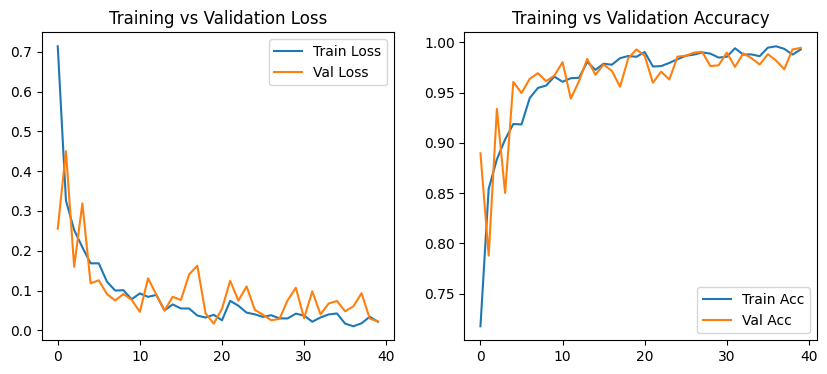

In [17]:
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\n✅ Final Test Loss: {test_loss:.4f}")
print(f"✅ Final Test Accuracy: {test_accuracy * 100:.2f}%")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

40/40 [==============================] - 10s 215ms/step
Confusion Matrix:
[[1027    4]
 [   3  234]]

Evaluation Metrics:
Accuracy : 99.45%
Precision: 99.01%
Recall   : 99.17%
F1-Score : 99.09%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1031
           1       0.98      0.99      0.99       237

    accuracy                           0.99      1268
   macro avg       0.99      0.99      0.99      1268
weighted avg       0.99      0.99      0.99      1268



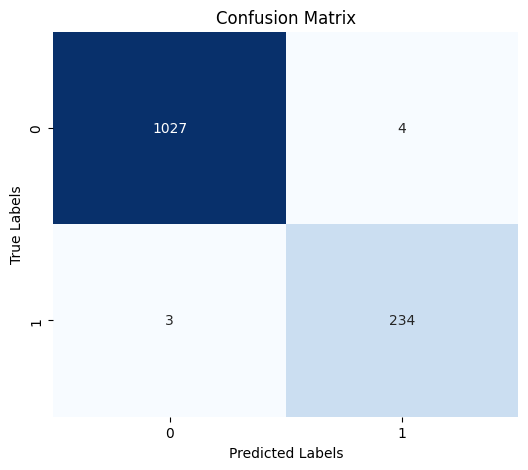

In [18]:
y_pred = model.predict(X_test_scaled)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Hitung metrik evaluasi
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')

# Cetak hasil evaluasi
print("\nEvaluation Metrics:")
print(f"Accuracy : {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall   : {recall*100:.2f}%")
print(f"F1-Score : {f1*100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Validation data

In [25]:
testing_dir = "./testing22"
class_names = ["Normal", "Jatuh"]
results = []

for class_name in os.listdir(testing_dir):
    class_path = os.path.join(testing_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        print(f"\nProcessing: {file_path}")

        df = pd.read_csv(file_path)
        grouped = df.groupby("timestamp")

        processed_frames = []
        dbscan_results = {}

        for frame_id, frame_points in grouped:
            if len(frame_points) < MIN_POINTS:
                continue

            xyz = frame_points[["x", "y", "z"]].to_numpy()
            db = DBSCAN(eps=eps_value, min_samples=3).fit(xyz)
            labels_db = db.labels_

            dbscan_results[frame_id] = labels_db

        if len(dbscan_results) == 0:
            print("  ❌ No usable frames")
            results.append({
                "file": file_name,
                "true_class": class_name,
                "predicted_class": "NO FRAMES"
            })
            continue

        # Regroup (generator exhausted)
        grouped = df.groupby("timestamp")

        # -----------------------------------------------
        # 2nd PASS – Extract largest cluster & bootstrap
        # -----------------------------------------------
        for frame_id, frame_points in grouped:
            if frame_id not in dbscan_results:
                continue

            labels_db = dbscan_results[frame_id]
            clusters = [c for c in set(labels_db) if c != -1]

            if len(clusters) == 0:
                continue

            largest = max(clusters, key=lambda c: np.sum(labels_db == c))
            mask = (labels_db == largest)

            cluster_points = frame_points.iloc[mask]

            # Bootstrap to 50 points
            if len(cluster_points) < TARGET_POINTS:
                cluster_points = cluster_points.sample(TARGET_POINTS, replace=True)
            else:
                cluster_points = cluster_points.sample(TARGET_POINTS, replace=False)

            numeric_cols = ["x", "y", "z", "doppler", "SNR", "Range", "Azimuth", "Elevation"]
            sigma = 0.01
            noise = np.random.normal(0, sigma, cluster_points[numeric_cols].shape)
            cluster_points.loc[:, numeric_cols] = cluster_points[numeric_cols] + noise

            # Extract 8 features
            feat = cluster_points[
                ["x","y","z","doppler","SNR", "Range", "Azimuth", "Elevation"]
            ].to_numpy()

            processed_frames.append(feat)

        # -----------------------------------------------
        # Sliding window (30 frames)
        # -----------------------------------------------
        windows = []
        if len(processed_frames) >= timesteps:
            for i in range(len(processed_frames) - timesteps + 1):
                windows.append(np.array(processed_frames[i:i+timesteps]))  # (30,50,8)
        else:
            print("  ❌ Not enough frames for sliding window")
            results.append({
                "file": file_name,
                "true_class": class_name,
                "predicted_class": "TOO SHORT"
            })
            continue

        windows = np.array(windows)   # (N,30,50,8)
        print(f"  ✓ Windows: {windows.shape}")

        # -----------------------------------------------
        # SCALE
        # -----------------------------------------------
        windows_rs = windows.reshape(-1, windows.shape[-1])
        windows_scaled = scaler.transform(windows_rs).reshape(windows.shape)

        print(f"  → Final input shape: {windows_scaled.shape}")

        # -----------------------------------------------
        # Predict
        # -----------------------------------------------
        predictions = model.predict(windows_scaled)
        window_classes = np.argmax(predictions, axis=1)

        print(window_classes)

        final_class = np.bincount(window_classes).argmax()
        print(f"  → Predicted: {class_names[final_class]}")

        results.append({
            "file": file_name,
            "true_class": class_name,
            "predicted_class": class_names[final_class]
        })

# ============================================================
# 4. SHOW RESULTS
# ============================================================
print("\n\n================ FINAL RESULTS ================")
for r in results:
    print(f"{r['file']} → TRUE={r['true_class']} | PRED={r['predicted_class']}")


Processing: ./testing22\Jalan\jalan1.csv
  ✓ Windows: (167, 30, 128, 8)
  → Final input shape: (167, 30, 128, 8)
6/6 [==============================] - 1s 130ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  → Predicted: Normal

Processing: ./testing22\Jalan\jalan2.csv
  ✓ Windows: (104, 30, 128, 8)
  → Final input shape: (104, 30, 128, 8)
4/4 [==============================] - 1s 117ms/step
[0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  → Predicted: Jatuh

Processing: ./testing22\Jalan\jalan3.csv
  ✓ Windows: (133, 30, 128, 8